In [1]:
import tensorflow as tf 
import numpy as np
import os

import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Model, Sequential
from keras.layers import Input

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D, Dense
from keras.layers import MaxPooling2D, Dropout, Flatten

import time

Using TensorFlow backend.


### Data Loading and Preprocessing.

In [2]:
from keras.datasets import cifar100
from keras.utils import np_utils

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

#scale and regularize the dataset
x_train = (x_train-np.mean(x_train))
x_test = (x_test - x_test.mean())

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#onehot encode the target classes
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)


train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(x_train,
                                     y = y_train,
                                    batch_size=80,)

### Model Construction

In [3]:
def conv_block_first(model, bn=False, dropout=False, rate=0.4, activation="relu"):
    """
    The first convolutional block in each architecture. Only seperate so we can 
    specify the input shape.
    """
    model.add(Conv2D(60,3, padding = "same", input_shape = x_train.shape[1:]))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))    
    model.add(Activation(activation))
    
    model.add(Conv2D(60,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))  
    model.add(Activation(activation))
    
    model.add(MaxPooling2D())
    return model

def conv_block(model, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    Generic convolutional block with 2 stacked 3x3 convolutions, max pooling, dropout, 
    and an optional Batch Normalization.
    """
    model.add(Conv2D(60,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))  
    model.add(Activation(activation))
    
    model.add(Conv2D(60,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))  
    model.add(Activation(activation))
    model.add(MaxPooling2D())
    return model

def conv_block_final(model, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    I bumped up the number of filters in the final block. I made this seperate so that
    I might be able to integrate Global Average Pooling later on. 
    """
    model.add(Conv2D(100,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))  
    model.add(Activation(activation))
    
    model.add(Conv2D(100,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))  
    model.add(Activation(activation))
    
    model.add(Flatten())
    return model

def fn_block(model):
    """
    I'm not going for a very deep fully connected block, mainly so I can save on memory.
    """
    model.add(Dense(100, activation = "softmax"))
    return model

def build_model(blocks=3, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    Builds a sequential network based on the specified parameters.
    
    blocks: number of convolutional blocks in the network, must be greater than 2.
    bn: whether to include batch normalization or not.
    activation: activation function to use throughout the network.
    """
    model = Sequential()
    
    model = conv_block_first(model, bn=bn, dropout=dropout, rate=rate, activation=activation)
    
    for block in range(1,blocks-1):
        model = conv_block(model, bn=bn, dropout=dropout, rate=rate, activation = activation)
        
    model = conv_block_final(model, bn=bn, dropout=dropout, rate=rate, activation=activation)
    model = fn_block(model)
    
    return model

def compile_model(model, optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"]): 
    """
    Compiles a neural network.
    
    model: the network to be compiled.
    optimizer: the optimizer to use.
    loss: the loss to use.
    metrics: a list of keras metrics.
    """
    model.compile(optimizer = optimizer,
                 loss = loss,
                 metrics = metrics)
    return model

### Compile Models

In [4]:
control = build_model(blocks = 5, bn=False, dropout=False, activation = "relu")
control = compile_model(control)

batchNorm = build_model(blocks = 5, bn=True, dropout=False, activation = "relu")
batchNorm = compile_model(batchNorm)

dropout5 = build_model(blocks = 5, bn=False, dropout=True, rate=0.5, activation = "relu")
dropout5 = compile_model(dropout5)

dropout3 = build_model(blocks = 5, bn=False, dropout=True, rate=0.3, activation = "relu")
dropout3 = compile_model(dropout3)

dropout1 = build_model(blocks = 5, bn=False, dropout=True, rate=0.1, activation = "relu")
dropout1 = compile_model(dropout1)

## Train the Models

### Control

In [5]:
start = time.time()
model_checkpoint = ModelCheckpoint('models/control.h5',
                                   save_best_only = True)

history1 = control.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=20,
        verbose=0,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  18.764877160390217  minutes


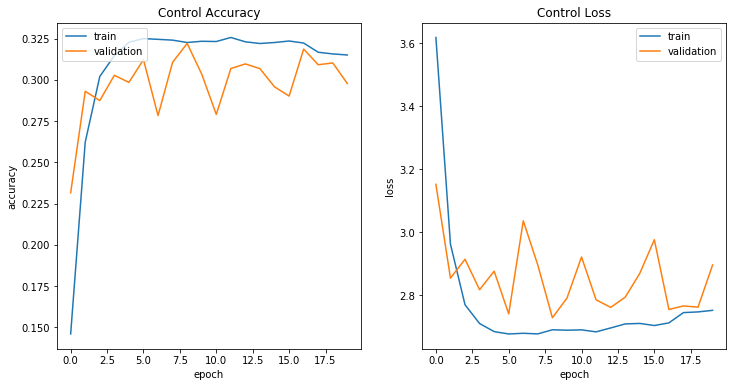

In [6]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Control Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Control Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Batch Normalization

In [7]:
start = time.time()

model_checkpoint = ModelCheckpoint('models/batchNorm.h5',
                                   save_best_only = True)

history2 = batchNorm.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        verbose=0,
        epochs=20,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  20.243623888492586  minutes


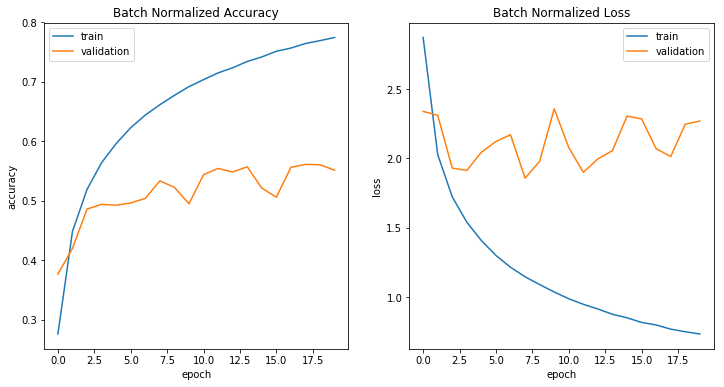

In [8]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Batch Normalized Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Batch Normalized Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Dropout 0.5

In [9]:
start = time.time()

model_checkpoint = ModelCheckpoint('models/Dropout5.h5',
                                   save_best_only = True)

history3 = dropout5.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        verbose=0,
        epochs=20,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  18.927210382620494  minutes


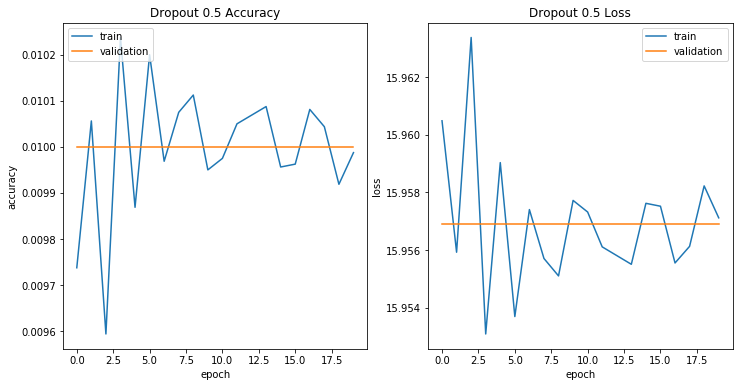

In [10]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('Dropout 0.5 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Dropout 0.5 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Dropout 0.3

In [11]:
start = time.time()

model_checkpoint = ModelCheckpoint('models/Dropout3.h5',
                                   save_best_only = True)

history4 = dropout3.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        verbose=0,
        epochs=20,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  19.82356542746226  minutes


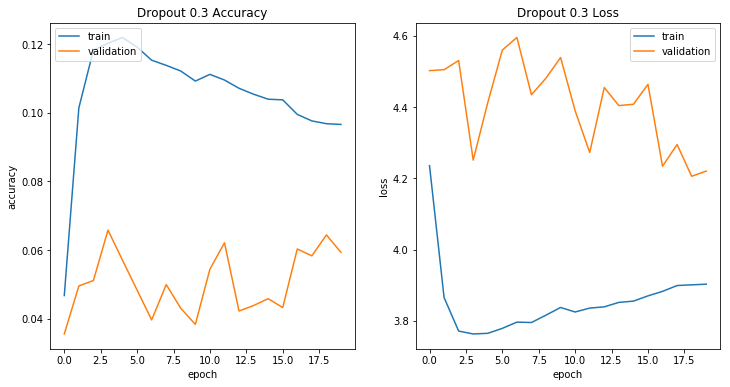

In [12]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('Dropout 0.3 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Dropout 0.3 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Dropout 0.1

In [13]:
start = time.time()

model_checkpoint = ModelCheckpoint('models/Dropout1.h5',
                                   save_best_only = True)

history5 = dropout1.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        verbose=0,
        epochs=20,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  21.16077136596044  minutes


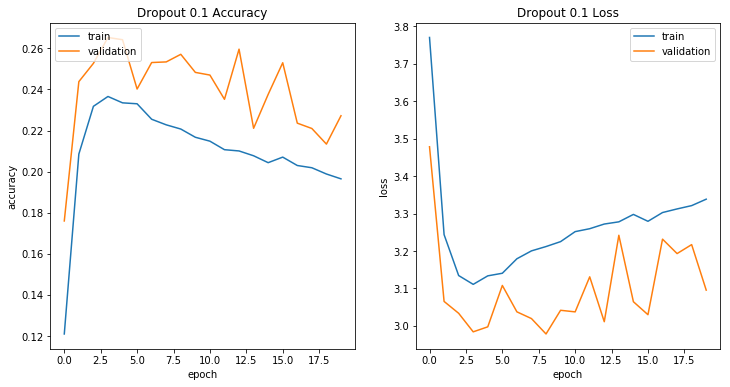

In [14]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('Dropout 0.1 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Dropout 0.1 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### All Together

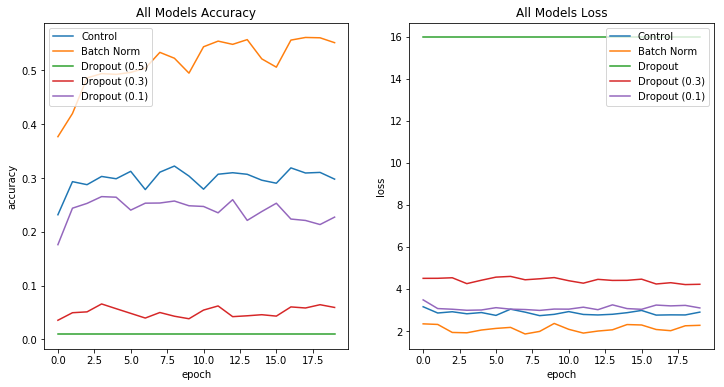

In [15]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history1.history['val_acc'])
plt.plot(history2.history['val_acc'])
plt.plot(history3.history['val_acc'])
plt.plot(history4.history['val_acc'])
plt.plot(history5.history['val_acc'])
plt.title('All Models Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Control', 'Batch Norm', 'Dropout (0.5)', 'Dropout (0.3)', 'Dropout (0.1)'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history3.history['val_loss'])
plt.plot(history4.history['val_loss'])
plt.plot(history5.history['val_loss'])

plt.title('All Models Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Control', 'Batch Norm', 'Dropout', 'Dropout (0.3)', 'Dropout (0.1)'], loc='upper right')
plt.show()

## What if we add dropout after maxpool instead of between conv layers?

In [16]:
def conv_block_first(model, bn=False, dropout=False, rate=0.4, activation="relu"):
    """
    The first convolutional block in each architecture. Only seperate so we can 
    specify the input shape.
    """
    model.add(Conv2D(60,3, padding = "same", input_shape = x_train.shape[1:]))   
    model.add(Activation(activation))
    
    model.add(Conv2D(60,3, padding = "same")) 
    model.add(Activation(activation))
    
    model.add(MaxPooling2D())
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate)) 
    return model

def conv_block(model, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    Generic convolutional block with 2 stacked 3x3 convolutions, max pooling, dropout, 
    and an optional Batch Normalization.
    """
    model.add(Conv2D(60,3, padding = "same"))
    model.add(Activation(activation))
    
    model.add(Conv2D(60,3, padding = "same")) 
    model.add(Activation(activation))
    
    model.add(MaxPooling2D())
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate)) 
    return model

def conv_block_final(model, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    I bumped up the number of filters in the final block. I made this seperate so that
    I might be able to integrate Global Average Pooling later on. 
    """
    model.add(Conv2D(100,3, padding = "same")) 
    model.add(Activation(activation))
    
    model.add(Conv2D(100,3, padding = "same")) 
    model.add(Activation(activation))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate)) 

    
    model.add(Flatten())
    return model

def fn_block(model):
    """
    I'm not going for a very deep fully connected block, mainly so I can save on memory.
    """
    model.add(Dense(100, activation = "softmax"))
    return model

def build_model(blocks=3, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    Builds a sequential network based on the specified parameters.
    
    blocks: number of convolutional blocks in the network, must be greater than 2.
    bn: whether to include batch normalization or not.
    activation: activation function to use throughout the network.
    """
    model = Sequential()
    
    model = conv_block_first(model, bn=bn, dropout=dropout, rate=rate, activation=activation)
    
    for block in range(1,blocks-1):
        model = conv_block(model, bn=bn, dropout=dropout, rate=rate, activation = activation)
        
    model = conv_block_final(model, bn=bn, dropout=dropout, rate=rate, activation=activation)
    model = fn_block(model)
    
    return model

def compile_model(model, optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"]): 
    """
    Compiles a neural network.
    
    model: the network to be compiled.
    optimizer: the optimizer to use.
    loss: the loss to use.
    metrics: a list of keras metrics.
    """
    model.compile(optimizer = optimizer,
                 loss = loss,
                 metrics = metrics)
    return model

In [17]:
control = build_model(blocks = 5, bn=False, dropout=False, activation = "relu")
control = compile_model(control)

batchNorm = build_model(blocks = 5, bn=True, dropout=False, activation = "relu")
batchNorm = compile_model(batchNorm)

dropout5 = build_model(blocks = 5, bn=False, dropout=True, rate=0.5, activation = "relu")
dropout5 = compile_model(dropout5)

dropout3 = build_model(blocks = 5, bn=False, dropout=True, rate=0.3, activation = "relu")
dropout3 = compile_model(dropout3)

dropout1 = build_model(blocks = 5, bn=False, dropout=True, rate=0.1, activation = "relu")
dropout1 = compile_model(dropout1)

### Control

In [18]:
start = time.time()
model_checkpoint = ModelCheckpoint('models/control_2.h5',
                                   save_best_only = True)

history6 = control.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=20,
        verbose=0,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  19.830950057506563  minutes


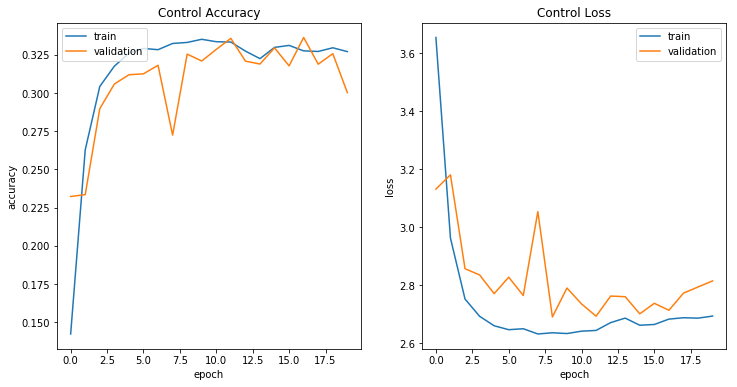

In [19]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history6.history['acc'])
plt.plot(history6.history['val_acc'])
plt.title('Control Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Control Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Batch Norm

In [20]:
start = time.time()

model_checkpoint = ModelCheckpoint('models/batchNorm2.h5',
                                   save_best_only = True)

history7 = batchNorm.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        verbose=0,
        epochs=20,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  19.9207448164622  minutes


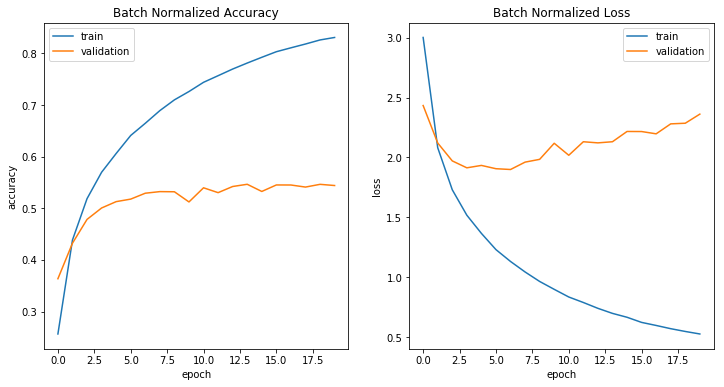

In [21]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history7.history['acc'])
plt.plot(history7.history['val_acc'])
plt.title('Batch Normalized Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Batch Normalized Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Dropout 0.5

In [22]:
start = time.time()

model_checkpoint = ModelCheckpoint('models/Dropout52.h5',
                                   save_best_only = True)

history8 = dropout5.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        verbose=0,
        epochs=20,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  19.950677212079366  minutes


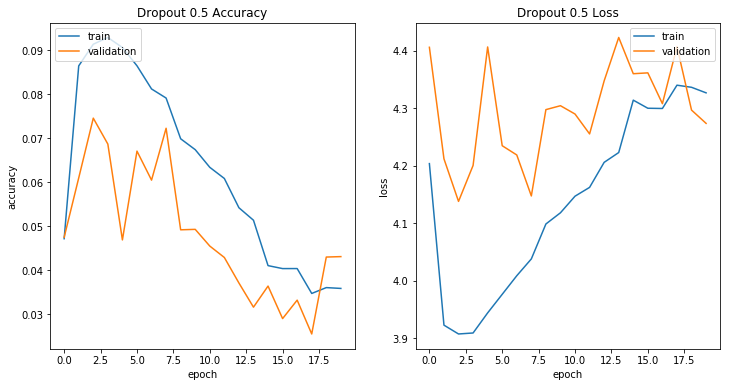

In [23]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history8.history['acc'])
plt.plot(history8.history['val_acc'])
plt.title('Dropout 0.5 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('Dropout 0.5 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Dropout 0.3

In [24]:
start = time.time()

model_checkpoint = ModelCheckpoint('models/Dropout32.h5',
                                   save_best_only = True)

history9 = dropout3.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        verbose=0,
        epochs=20,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  19.387265388170878  minutes


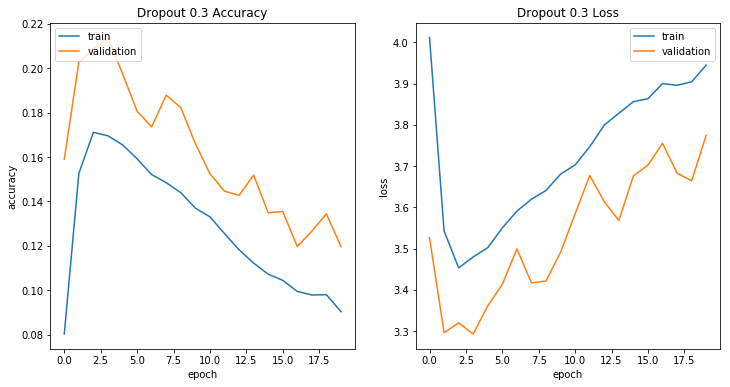

In [25]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history9.history['acc'])
plt.plot(history9.history['val_acc'])
plt.title('Dropout 0.3 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history9.history['loss'])
plt.plot(history9.history['val_loss'])
plt.title('Dropout 0.3 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Dropout 0.1

In [26]:
start = time.time()

model_checkpoint = ModelCheckpoint('models/Dropout12.h5',
                                   save_best_only = True)

history10 = dropout1.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        verbose=0,
        epochs=20,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  19.244329166412353  minutes


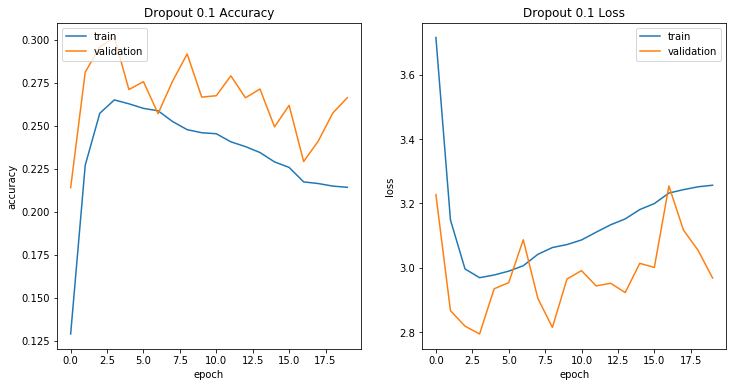

In [27]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history10.history['acc'])
plt.plot(history10.history['val_acc'])
plt.title('Dropout 0.1 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history10.history['loss'])
plt.plot(history10.history['val_loss'])
plt.title('Dropout 0.1 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### All Together

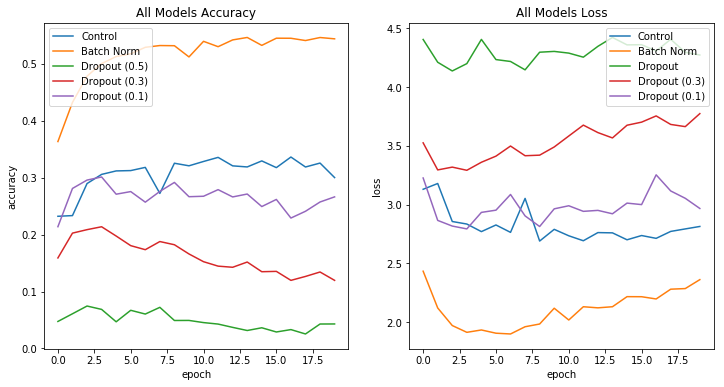

In [28]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history6.history['val_acc'])
plt.plot(history7.history['val_acc'])
plt.plot(history8.history['val_acc'])
plt.plot(history9.history['val_acc'])
plt.plot(history10.history['val_acc'])
plt.title('All Models Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Control', 'Batch Norm', 'Dropout (0.5)', 'Dropout (0.3)', 'Dropout (0.1)'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history6.history['val_loss'])
plt.plot(history7.history['val_loss'])
plt.plot(history8.history['val_loss'])
plt.plot(history9.history['val_loss'])
plt.plot(history10.history['val_loss'])

plt.title('All Models Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Control', 'Batch Norm', 'Dropout', 'Dropout (0.3)', 'Dropout (0.1)'], loc='upper right')
plt.show()

## What if we add dropout and bn after activations?


In [29]:
def conv_block_first(model, bn=False, dropout=False, rate=0.4, activation="relu"):
    """
    The first convolutional block in each architecture. Only seperate so we can 
    specify the input shape.
    """
    model.add(Conv2D(60,3, padding = "same", input_shape = x_train.shape[1:]))
    model.add(Activation(activation))
    if bn:
        model.add(BatchNormalization())    
    if dropout:
        model.add(Dropout(rate)) 
    
    model.add(Conv2D(60,3, padding = "same"))
    model.add(Activation(activation))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate)) 
    
    model.add(MaxPooling2D())
    return model

def conv_block(model, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    Generic convolutional block with 2 stacked 3x3 convolutions, max pooling, dropout, 
    and an optional Batch Normalization.
    """
    model.add(Conv2D(60,3, padding = "same"))
    model.add(Activation(activation))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate)) 
    
    model.add(Conv2D(60,3, padding = "same"))
    model.add(Activation(activation))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate)) 
        
    model.add(MaxPooling2D())
    return model

def conv_block_final(model, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    I bumped up the number of filters in the final block. I made this seperate so that
    I might be able to integrate Global Average Pooling later on. 
    """
    model.add(Conv2D(100,3, padding = "same"))
    model.add(Activation(activation))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate)) 
    
    model.add(Conv2D(100,3, padding = "same"))
    model.add(Activation(activation))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate)) 
        
    model.add(Flatten())
    return model

def fn_block(model):
    """
    I'm not going for a very deep fully connected block, mainly so I can save on memory.
    """
    model.add(Dense(100, activation = "softmax"))
    return model

def build_model(blocks=3, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    Builds a sequential network based on the specified parameters.
    
    blocks: number of convolutional blocks in the network, must be greater than 2.
    bn: whether to include batch normalization or not.
    activation: activation function to use throughout the network.
    """
    model = Sequential()
    
    model = conv_block_first(model, bn=bn, dropout=dropout, rate=rate, activation=activation)
    
    for block in range(1,blocks-1):
        model = conv_block(model, bn=bn, dropout=dropout, rate=rate, activation = activation)
        
    model = conv_block_final(model, bn=bn, dropout=dropout, rate=rate, activation=activation)
    model = fn_block(model)
    
    return model

def compile_model(model, optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"]): 
    """
    Compiles a neural network.
    
    model: the network to be compiled.
    optimizer: the optimizer to use.
    loss: the loss to use.
    metrics: a list of keras metrics.
    """
    model.compile(optimizer = optimizer,
                 loss = loss,
                 metrics = metrics)
    return model

control = build_model(blocks = 5, bn=False, dropout=False, activation = "relu")
control = compile_model(control)

batchNorm = build_model(blocks = 5, bn=True, dropout=False, activation = "relu")
batchNorm = compile_model(batchNorm)

dropout5 = build_model(blocks = 5, bn=False, dropout=True, rate=0.5, activation = "relu")
dropout5 = compile_model(dropout5)

dropout3 = build_model(blocks = 5, bn=False, dropout=True, rate=0.3, activation = "relu")
dropout3 = compile_model(dropout3)

dropout1 = build_model(blocks = 5, bn=False, dropout=True, rate=0.1, activation = "relu")
dropout1 = compile_model(dropout1)

### Control

In [30]:
start = time.time()
model_checkpoint = ModelCheckpoint('models/control3.h5',
                                   save_best_only = True)

history11 = control.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=20,
        verbose=0,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  20.11558248202006  minutes


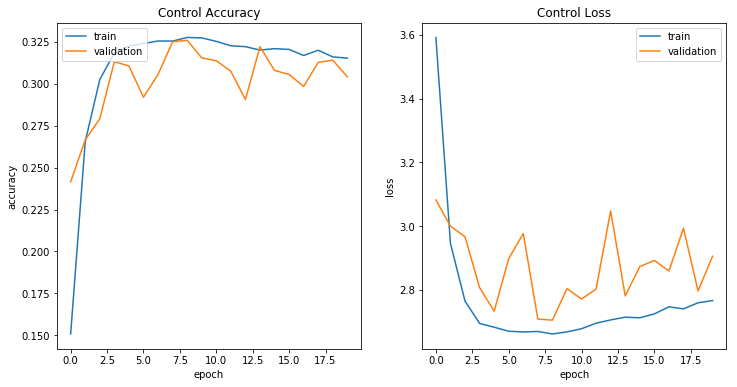

In [31]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history11.history['acc'])
plt.plot(history11.history['val_acc'])
plt.title('Control Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history11.history['loss'])
plt.plot(history11.history['val_loss'])
plt.title('Control Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Batch Norm

In [32]:
start = time.time()

model_checkpoint = ModelCheckpoint('models/batchNorm3.h5',
                                   save_best_only = True)

history12 = batchNorm.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        verbose=0,
        epochs=20,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  22.23410782019297  minutes


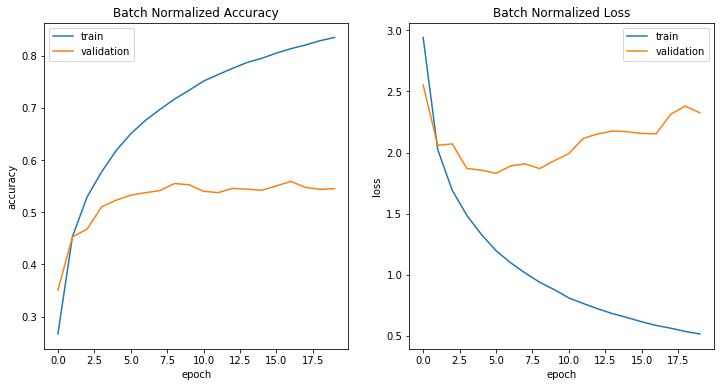

In [33]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history12.history['acc'])
plt.plot(history12.history['val_acc'])
plt.title('Batch Normalized Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history12.history['loss'])
plt.plot(history12.history['val_loss'])
plt.title('Batch Normalized Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Dropout 0.5

In [34]:
start = time.time()

model_checkpoint = ModelCheckpoint('models/Dropout53.h5',
                                   save_best_only = True)

history13 = dropout5.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        verbose=0,
        epochs=20,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  20.63536934455236  minutes


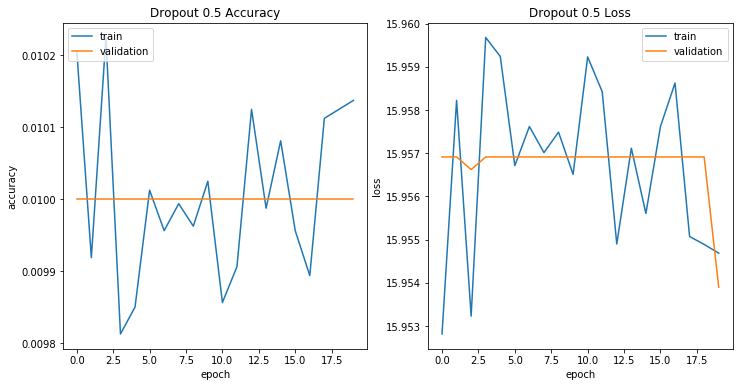

In [35]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history13.history['acc'])
plt.plot(history13.history['val_acc'])
plt.title('Dropout 0.5 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history13.history['loss'])
plt.plot(history13.history['val_loss'])
plt.title('Dropout 0.5 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Dropout 0.3

In [36]:
start = time.time()

model_checkpoint = ModelCheckpoint('models/Dropout33.h5',
                                   save_best_only = True)

history14 = dropout3.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        verbose=0,
        epochs=20,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  21.135031247138976  minutes


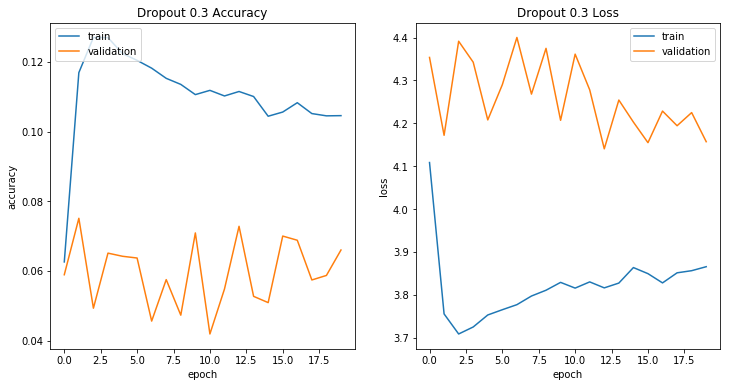

In [37]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history14.history['acc'])
plt.plot(history14.history['val_acc'])
plt.title('Dropout 0.3 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history14.history['loss'])
plt.plot(history14.history['val_loss'])
plt.title('Dropout 0.3 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Dropout 0.1

In [38]:
start = time.time()

model_checkpoint = ModelCheckpoint('models/Dropout13.h5',
                                   save_best_only = True)

history15 = dropout1.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        verbose=0,
        epochs=20,
        validation_data=(x_test, y_test),
        callbacks = [model_checkpoint])

end = time.time()

print("Training time: ", (end - start)/60, " minutes")

Training time:  19.722562642892203  minutes


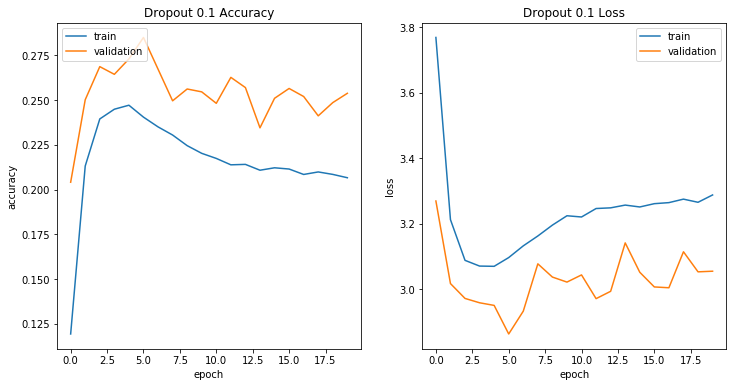

In [39]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history15.history['acc'])
plt.plot(history15.history['val_acc'])
plt.title('Dropout 0.1 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history15.history['loss'])
plt.plot(history15.history['val_loss'])
plt.title('Dropout 0.1 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### All Together

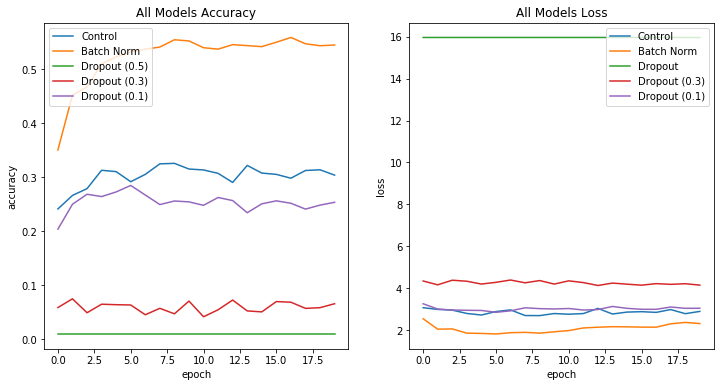

In [40]:
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.subplot(121)
plt.plot(history11.history['val_acc'])
plt.plot(history12.history['val_acc'])
plt.plot(history13.history['val_acc'])
plt.plot(history14.history['val_acc'])
plt.plot(history15.history['val_acc'])
plt.title('All Models Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Control', 'Batch Norm', 'Dropout (0.5)', 'Dropout (0.3)', 'Dropout (0.1)'], loc='upper left')
# summarize history for loss
plt.subplot(122)
plt.plot(history11.history['val_loss'])
plt.plot(history12.history['val_loss'])
plt.plot(history13.history['val_loss'])
plt.plot(history14.history['val_loss'])
plt.plot(history15.history['val_loss'])

plt.title('All Models Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Control', 'Batch Norm', 'Dropout', 'Dropout (0.3)', 'Dropout (0.1)'], loc='upper right')
plt.show()